# MS028 Preprocess
06/27/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS028'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Data

In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [7]:
mne_data

<RawEDF | MS028_SWB.edf, 276 x 2194048 (2142.6 s), ~4.51 GB, data loaded>

In [8]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'LCMmM1',
 'LCMmM2',
 'LCMmM3',
 'LCMmM4',
 'LCMmM5',
 'LCMmM6',
 'LCMmM7',
 'LCMmM8',
 'LCMmM9',
 'LCMmM10',
 'LCMmM11',
 'LCMmM12',
 'LCMmM13',
 'LCMmM14',
 'RCMmM1',
 'RCMmM2',
 'RCMmM3',
 'RCMmM4',
 'RCMmM5',
 'RCMmM6',
 'RCMmM7',
 'RCMmM8',
 'RCMmM9',
 'RCMmM10',
 'RCMmM11',
 'RCMmM12',
 'RCMmM13',
 'RCMmM14',
 'LalpS1',
 'LalpS2',
 'LalpS3',
 'LalpS4',
 'LalpS5',
 'LalpS6',
 'LalpS7',
 'LalpS8',
 'LalpS9',
 'LalpS10',
 'LalpS11',
 'LalpS12',
 'LalpS13',
 'LalpS14',
 'LalpS15',
 'LalpS16',
 'C63',
 'C64',
 'RlmS1',
 'RlmS2',
 'RlmS3',
 'RlmS4',
 'RlmS5',
 'RlmS6',
 'RlmS7',
 'RlmS8',
 'RlmS9',
 'RlmS10',
 'RlmS11',
 'RlmS12',
 'RlmS13',
 'RlmS14',
 'RlmS15',
 'RlmS16',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS

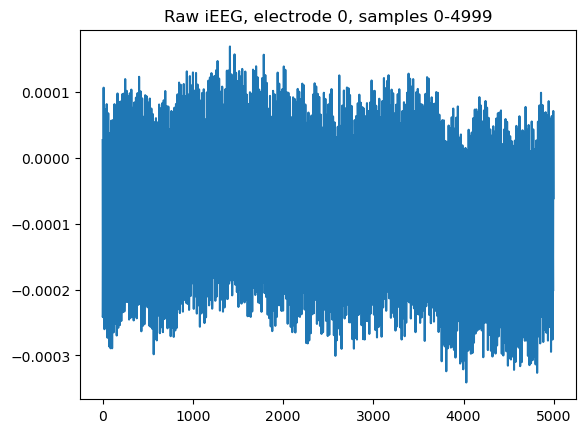

In [9]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Examine photodiode

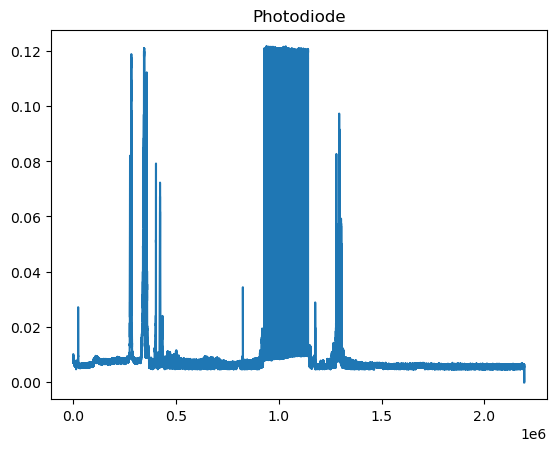

In [10]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


### Fix edf channel names

In [11]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x      mni_y  \
0    LAglT1    mAmyg_L -22.353151  11.990105 -12.842655 -24.030008  -2.466548   
1    LAglT2    lAmyg_L -27.152578  11.990105 -11.243587 -29.338226  -2.282588   
2    LAglT3    Unknown -31.952006  12.389775 -10.044287 -34.646184  -1.732659   
3    LAglT4  vId/vIg_L -36.751433  12.389775  -8.445219 -39.885009  -1.486931   
4    LAglT5     A38l_L -41.550861  12.789446  -7.245918 -45.108698  -0.767422   
..      ...        ...        ...        ...        ...        ...        ...   
161  RmOlF9    A44op_R  35.639932  35.170976  11.942894  39.015475  30.366030   
162  uLAglT    rHipp_L -17.953676  11.190765 -14.041956 -19.136886  -3.331668   
163  uLmOlF      A13_L  -7.554916  38.768008 -10.044287  -8.831674  27.220768   
164  uRAglT    mAmyg_R  18.042031   7.993403 -12.043121  19.030036  -5.166208   
165  uRmOlF      A13_R   2.043939  35.170976 -14.441723   1.775865  23.012354   

         mni_z     gm                                                NMM  \
0   -21.004349   Gray                                      Left Amygdala   
1   -19.243495   Gray                           Left Ent entorhinal area   
2   -18.001756  White                         Left Cerebral White Matter   
3   -16.129432   Gray                         Left PIns posterior insula   
4   -14.632926   Gray                              Left PP planum polare   
..         ...    ...                                                ...   
161   0.328881   Gray  Right TrIFG triangular part of the inferior fr...   
162 -22.148985   Gray                                      Left Amygdala   
163 -22.979829   Gray                              Left GRe gyrus rectus   
164 -20.077131   Gray                                     Right Amygdala   
165 -27.216116   Gray                             Right GRe gyrus rectus   

              Anat                  AnatMacro    BN246  \
0    Amygdala (LB)                 L Amygdala   L Amyg   
1    Amygdala (LB)                 L Amygdala   L Amyg   
2          Unknown                    Unknown  Unknown   
3         Area Id1  L Superior Temporal Gyrus    L INS   
4          Unknown  L Superior Temporal Gyrus    L STG   
..             ...                        ...      ...   
161        Unknown     R IFG (p Triangularis)    R IFG   
162  Amygdala (LB)              L Hippocampus   L Hipp   
163       Area Fo2             L Rectal Gyrus    L OrG   
164  Amygdala (SF)    R ParaHippocampal Gyrus   R Amyg   
165       Area Fo2             L Rectal Gyrus    R OrG   

                                  YBA_1 Manual Examination       Notes  
0               Left amygdala superior                 NaN         NaN  
1               Left amygdala superior                 NaN         NaN  
2                               Unknown                NaN         NaN  
3        Left superior temporal gyrus A                NaN         NaN  
4        Left superior temporal gyrus A                NaN  Borderline  
..                                  ...                ...         ...  
161  Right anterior pars triangularis B                NaN         NaN  
162              Left amygdala inferior                NaN         NaN  
163            Left frontal orbital 5 A                NaN         NaN  
164            Right amygdala superior                 NaN         NaN  
165           Right frontal orbital 5 A                NaN         NaN  

[166 rows x 16 columns]

In [12]:
list(elec_locs.label)

['LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LCMmM1',
 'LCMmM10',
 'LCMmM11',
 'LCMmM12',
 'LCMmM13',
 'LCMmM14',
 'LCMmM2',
 'LCMmM3',
 'LCMmM4',
 'LCMmM5',
 'LCMmM6',
 'LCMmM7',
 'LCMmM8',
 'LCMmM9',
 'LHplT1',
 'LHplT10',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaIpS1',
 'LaIpS10',
 'LaIpS11',
 'LaIpS12',
 'LaIpS13',
 'LaIpS14',
 'LaIpS15',
 'LaIpS16',
 'LaIpS2',
 'LaIpS3',
 'LaIpS4',
 'LaIpS5',
 'LaIpS6',
 'LaIpS7',
 'LaIpS8',
 'LaIpS9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RAglT1',
 'RAglT2',
 'RAglT3',
 'RAglT4',
 'RAglT5',
 'RAglT6',
 'RAglT7',
 'RAglT8',
 'RAglT9',
 'RC

In [13]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


In [14]:
unmatched_names

['ulaglt', 'urmolf', 'uraglt', 'ulmolf']

In [15]:
unmatched_seeg  #make sure there are no unmatched names

[]

In [16]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [17]:
new_name_dict

{'LmOlF1': 'lmolf1',
 'LmOlF2': 'lmolf2',
 'LmOlF3': 'lmolf3',
 'LmOlF4': 'lmolf4',
 'LmOlF5': 'lmolf5',
 'LmOlF6': 'lmolf6',
 'LmOlF7': 'lmolf7',
 'LmOlF8': 'lmolf8',
 'LmOlF9': 'lmolf9',
 'RmOlF1': 'rmolf1',
 'RmOlF2': 'rmolf2',
 'RmOlF3': 'rmolf3',
 'RmOlF4': 'rmolf4',
 'RmOlF5': 'rmolf5',
 'RmOlF6': 'rmolf6',
 'RmOlF7': 'rmolf7',
 'RmOlF8': 'rmolf8',
 'RmOlF9': 'rmolf9',
 'LCMmM1': 'lcmmm1',
 'LCMmM2': 'lcmmm2',
 'LCMmM3': 'lcmmm3',
 'LCMmM4': 'lcmmm4',
 'LCMmM5': 'lcmmm5',
 'LCMmM6': 'lcmmm6',
 'LCMmM7': 'lcmmm7',
 'LCMmM8': 'lcmmm8',
 'LCMmM9': 'lcmmm9',
 'LCMmM10': 'lcmmm10',
 'LCMmM11': 'lcmmm11',
 'LCMmM12': 'lcmmm12',
 'LCMmM13': 'lcmmm13',
 'LCMmM14': 'lcmmm14',
 'RCMmM1': 'rcmmm1',
 'RCMmM2': 'rcmmm2',
 'RCMmM3': 'rcmmm3',
 'RCMmM4': 'rcmmm4',
 'RCMmM5': 'rcmmm5',
 'RCMmM6': 'rcmmm6',
 'RCMmM7': 'rcmmm7',
 'RCMmM8': 'rcmmm8',
 'RCMmM9': 'rcmmm9',
 'RCMmM10': 'rcmmm10',
 'RCMmM11': 'rcmmm11',
 'RCMmM12': 'rcmmm12',
 'RCMmM13': 'rcmmm13',
 'RCMmM14': 'rcmmm14',
 'LalpS1': 'la

In [18]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS028_SWB.edf, 276 x 2194048 (2142.6 s), ~4.51 GB, data loaded>

In [19]:
unmatched_seeg

[]

In [20]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c63', 'c64', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'abs1', 'abs2', 'chest1', 'chest2', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc1', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [21]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 80 left & 82 right sEEG electrodes
We have a total of 162 sEEG electrodes


In [21]:
list(set(mne_data.ch_names)^set(le
                                ft_seeg_names+right_seeg_names+['dc1'])) #list of non seeg/photodiode channels

['c254',
 't5',
 'c252',
 'c222',
 'c220',
 'c216',
 'c250',
 'c188',
 'c229',
 'c206',
 'c214',
 'fz',
 'c198',
 'c215',
 'c256',
 'dc13',
 'c249',
 'c63',
 'c240',
 'c233',
 'c243',
 'dc14',
 'o1',
 'ekg2',
 'c231',
 'c227',
 'p4',
 'c207',
 'c199',
 'c230',
 'pleth',
 'c241',
 'c245',
 'c3',
 'ekg1',
 'c194',
 'c208',
 'c190',
 'c218',
 'c221',
 'dc8',
 'pr',
 'fp1',
 't4',
 'c4',
 'c225',
 'dc10',
 'c255',
 'dc5',
 'osat',
 'c244',
 'c200',
 'dc16',
 'c248',
 'c236',
 't3',
 'c205',
 'dc15',
 'pz',
 'c204',
 'f7',
 'c202',
 'f8',
 'c237',
 'c251',
 'c224',
 'c201',
 'c183',
 'c182',
 'cz',
 'c253',
 'c210',
 'c247',
 'c192',
 'c193',
 'c212',
 'dc4',
 'c228',
 'c217',
 'dc11',
 'c196',
 'c235',
 'c232',
 'c187',
 'c223',
 'c239',
 'c209',
 'fp2',
 'c186',
 'c191',
 'f3',
 'c238',
 'trig',
 'dc7',
 'c213',
 'c203',
 'c246',
 'dc2',
 't6',
 'dc9',
 'c197',
 'c185',
 'c234',
 'c189',
 'c226',
 'c64',
 'c211',
 'f4',
 'dc3',
 'p3',
 'c184',
 'dc12',
 'c195',
 'c219',
 'dc6',
 'c242',
 

In [22]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS028_SWB.edf, 163 x 2194048 (2142.6 s), ~2.66 GB, data loaded>

In [23]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'dc1':'stim'} #stim stands for stimulus
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS028_SWB.edf, 163 x 2194048 (2142.6 s), ~2.66 GB, data loaded>

In [24]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS028_SWB.edf, 163 x 2194048 (2142.6 s), ~2.66 GB, data loaded>

### Notch filter line noise

In [25]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:    9.2s finished


<RawEDF | MS028_SWB.edf, 163 x 2194048 (2142.6 s), ~2.66 GB, data loaded>

### Resampling Data

In [26]:
#resampling if patient is not sampled at 512
resample_sr = 512
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 163 out of 163 | elapsed:   14.2s finished


<RawEDF | MS028_SWB.edf, 163 x 1097024 (2142.6 s), ~1.33 GB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise and resampling

In [27]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='dc1', overwrite=True)

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [28]:
#make_mne function auto-detects bad electrodes. I want to compare auto vs manual ictal detection

bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #worked perfectly for this pt besides photodiode
mne_data.info['bads'] = bads

In [29]:
bads #bads picked up research? - manually remove
#bads = bads[:-1]
#bads

['laips6', 'lcmmm8', 'lcmmm9', 'raglt8', 'rmcms8']

In [30]:
mne_data.info['bads'] = bads

In [31]:
mne_data.info

<Info | 10 non-empty values
 bads: 5 items (laips6, lcmmm8, lcmmm9, raglt8, rmcms8)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 162 sEEG
 custom_ref_applied: False
 dig: 162 items (162 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 10:31:03 UTC
 nchan: 162
 projs: []
 sfreq: 512.0 Hz
>

In [32]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [33]:
probe_names

array(['lacas', 'laglt', 'laips', 'lcmmm', 'lhplt', 'lmcms', 'lmolf',
       'racas', 'raglt', 'rcmmm', 'rhplt', 'rims', 'rmcms', 'rmolf',
       'ulaglt', 'ulmolf', 'uraglt', 'urmolf'], dtype='<U6')

In [34]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [35]:
probe_ch_counts

{'lacas': 12,
 'laglt': 9,
 'laips': 16,
 'lcmmm': 14,
 'lhplt': 10,
 'lmcms': 10,
 'lmolf': 9,
 'racas': 14,
 'raglt': 9,
 'rcmmm': 14,
 'rhplt': 10,
 'rims': 16,
 'rmcms': 10,
 'rmolf': 9,
 'ulaglt': 1,
 'ulmolf': 1,
 'uraglt': 1,
 'urmolf': 1}

<IPython.core.display.Javascript object>


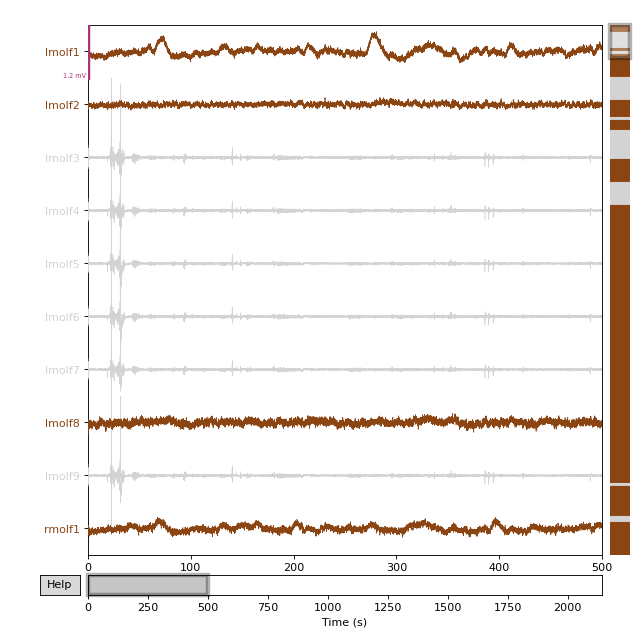

<IPython.core.display.Javascript object>


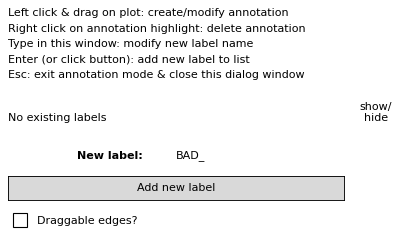

In [37]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=10, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [38]:
mne_data.info['bads']

['laips6',
 'raglt8',
 'lcmmm11',
 'lhplt9',
 'lhplt10',
 'lmolf3',
 'lmolf4',
 'lmolf5',
 'lmolf6',
 'lmolf7',
 'lmolf9',
 'rmolf8',
 'rmolf9',
 'lcmmm1',
 'lcmmm2',
 'lcmmm3',
 'lcmmm4',
 'lcmmm5',
 'rcmmm1',
 'rcmmm2',
 'rcmmm3',
 'rcmmm4',
 'rcmmm5',
 'rcmmm6',
 'rcmmm7',
 'rcmmm8',
 'rcmmm9',
 'laips3',
 'laips4',
 'laips5',
 'laips7',
 'laips8',
 'laips9']

In [39]:
#set bad channel info 
bad_ch = ['laips6',
 'raglt8',
 'lcmmm11',
 'lhplt9',
 'lhplt10',
 'lmolf3',
 'lmolf4',
 'lmolf5',
 'lmolf6',
 'lmolf7',
 'lmolf9',
 'rmolf8',
 'rmolf9',
 'lcmmm1',
 'lcmmm2',
 'lcmmm3',
 'lcmmm4',
 'lcmmm5',
 'rcmmm1',
 'rcmmm2',
 'rcmmm3',
 'rcmmm4',
 'rcmmm5',
 'rcmmm6',
 'rcmmm7',
 'rcmmm8',
 'rcmmm9',
 'laips3',
 'laips4',
 'laips5',
 'laips7',
 'laips8',
 'laips9']


In [40]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = bad_ch 

### Rereference data to wm electrodes

In [41]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [42]:
oob_channels

['laglt9',
 'lcmmm14',
 'lacas11',
 'lacas12',
 'laips14',
 'laips15',
 'laips16',
 'lmcms10',
 'raglt9',
 'rcmmm14',
 'rhplt10',
 'rims15',
 'rims16',
 'racas12',
 'racas13',
 'racas14',
 'rmcms10']

In [43]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
bad_ch = bad_ch + oob_channels
bad_ch = list(np.unique(bad_ch))
mne_data.info['bads'] = bad_ch

In [44]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lacas11',
 'lacas12',
 'laglt9',
 'laips14',
 'laips15',
 'laips16',
 'laips3',
 'laips4',
 'laips5',
 'laips6',
 'laips7',
 'laips8',
 'laips9',
 'lcmmm1',
 'lcmmm11',
 'lcmmm14',
 'lcmmm2',
 'lcmmm3',
 'lcmmm4',
 'lcmmm5',
 'lhplt10',
 'lhplt9',
 'lmcms10',
 'lmolf3',
 'lmolf4',
 'lmolf5',
 'lmolf6',
 'lmolf7',
 'lmolf9',
 'racas12',
 'racas13',
 'racas14',
 'raglt8',
 'raglt9',
 'rcmmm1',
 'rcmmm14',
 'rcmmm2',
 'rcmmm3',
 'rcmmm4',
 'rcmmm5',
 'rcmmm6',
 'rcmmm7',
 'rcmmm8',
 'rcmmm9',
 'rhplt10',
 'rims15',
 'rims16',
 'rmcms10',
 'rmolf8',
 'rmolf9']

In [45]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [46]:
mne_data_reref

<RawEDF | MS028_SWB.edf, 130 x 1097024 (2142.6 s), ~1.06 GB, data loaded>

### Save cleaned continuous data

In [47]:
mne_data.save(f'{neural_dir}{subj_id}/lfp_data.fif',overwrite=True)

In [48]:
mne_data_reref.save(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif',overwrite=True)